## Prepare Data

In [0]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_all = x_train_all.reshape(-1, 28*28)/255.0
x_test = x_test.reshape(-1,28*28)/255.0

x_train, x_val, y_train, y_val = train_test_split(x_train_all.astype(np.float32), y_train_all.astype(np.int32), test_size=5000)

In [0]:
import matplotlib.pyplot as plt

def show_digits(X_batch):
    batch_size=len(X_batch)
    plt.figure(figsize=(3, 3 * batch_size))
    plt.subplot(121)
    plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", 
               interpolation="nearest")
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", 
               interpolation="nearest")
    plt.axis('off')
    plt.show()

(55000, 2, 784)
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]]


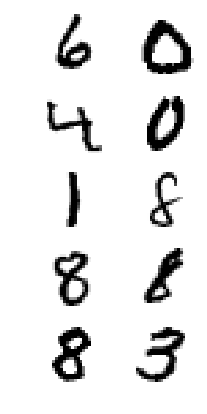

In [0]:
def get_compare_dataset(x_train, y_train):
    
    x_images1, x_images2, is_equal = [[],[],[]]
    for val in np.unique(y_train):
        indxes = np.arange(len(y_train), dtype=np.int32)
        val_bool_index = (y_train==val)
        
        val_indxes = indxes[val_bool_index]
        other_indxes = indxes[~val_bool_index]
        
        half_len = len(val_indxes)//2
        x_images1.append(x_train[np.random.choice(val_indxes, half_len)])
        x_images2.append(x_train[np.random.choice(val_indxes, half_len)])
        is_equal.append(np.ones(half_len))
        
        
        other_len = len(val_indxes) - half_len
        x_images1.append(x_train[np.random.choice(val_indxes, other_len)])
        x_images2.append(x_train[np.random.choice(other_indxes, other_len)])
        is_equal.append(np.zeros(other_len))
        
    x_images1, x_images2, is_equal = (np.concatenate(x_images1), np.concatenate(x_images2) \
                ,np.concatenate(is_equal))

    x_images = np.c_[x_images1, x_images2].reshape(-1,2,x_train.shape[1])

    shufffle_index = np.random.permutation(len(is_equal))
    
    return x_images[shufffle_index].copy(), is_equal[shufffle_index].reshape(-1,1)
 
## TEST
x_images_, is_equal_ = get_compare_dataset(x_train, y_train)
print(x_images_.shape)
rnd_indx = np.random.choice(len(is_equal_), 5)
print(is_equal_[rnd_indx])
show_digits(x_images_[rnd_indx])

### Training and Validation data

In [0]:
x_images_train, y_is_equal_train = get_compare_dataset(x_train, y_train)
x_images_val, y_is_equal_val = get_compare_dataset(x_val, y_val)

## Utility Functions

In [0]:
import tensorflow as tf
from tensorflow.contrib.layers import variance_scaling_initializer as he_initializer
from tensorflow.layers import dense
import numpy as np


def get_connected_layers(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_initializer):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer(),
                                     name="hidden%d" % (layer + 1))
        return inputs


def get_optimizer_op(optimizer, loss, learning_rate=0.01):
    with tf.name_scope("train"):
        optimizer =  optimizer(learning_rate=learning_rate)
        optimizer_op = optimizer.minimize(loss, name="optimizer_op")
    return optimizer_op
    
def get_batch(x,y,batch_size):
    n_batches = len(y)//batch_size + 1
    for i in range(n_batches):
        indxes = np.random.choice(len(y), size=batch_size, replace=False)
        yield x[indxes], y[indxes]



## Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

## Create Class Compare Images

In [0]:
class DNN_Comparer():
    
    def __init__(self, n_hidden_layers=None, n_neurons=None, n_outputs=None, 
                 activation=tf.nn.elu, optimizer=tf.train.AdamOptimizer,  learning_rate=0.01, 
                 batch_norm_momentum=None, batch_size=50, dropout_rate=None):
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.batch_norm_momentum = batch_norm_momentum
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.n_outputs = n_outputs
        self._session = None
        model_save_name= "ch11_5_excercise_compare"
        self._save_path = F"/content/gdrive/My Drive/Colab Notebooks/checkpoints/{model_save_name}"
    
    def _create_graph(self):
        tf.reset_default_graph()
        
        
        self._images = tf.placeholder(shape=(None, 2, 28*28), dtype=tf.float32,name="x")
        self._image1, self._image2 = tf.unstack(self._images, axis=1)

        self._is_equal = tf.placeholder(shape=(None,1), dtype=tf.int32,name="y")

        with tf.variable_scope("dnn1"):
            dnn1 = get_connected_layers(self._image1)

        with tf.variable_scope("dnn2"):
            dnn2 = get_connected_layers(self._image2)

        combined_dnn = tf.concat([dnn1, dnn2], axis=1, name="combined_dnn")

        hidden_new = tf.layers.dense(combined_dnn, 10, name="hidden_new", activation=tf.nn.elu
                                     , kernel_initializer=he_initializer())
        self._output = tf.layers.dense(hidden_new, 1, name="output", kernel_initializer=he_initializer())

        is_equal_float=tf.cast(self._is_equal, tf.float32)
        entropy=tf.nn.sigmoid_cross_entropy_with_logits(labels=is_equal_float, 
                                                        logits=self._output)

        self._loss = tf.reduce_mean(entropy)

#         self._optimizer_op = get_optimizer_op(self.optimizer, self._loss, 
#                                               self.learning_rate)

        momentum = 0.99
  

        optimizer = tf.train.MomentumOptimizer(self.learning_rate, momentum, use_nesterov=True)
        self._optimizer_op = optimizer.minimize(self._loss)


#         self._batch_norm_update_ops = self._graph.get_collection(tf.GraphKeys.UPDATE_OPS)

        self._preds = tf.cast(tf.greater_equal(self._output, 0), tf.int32)
        self._accuracy =tf.reduce_mean(tf.cast(tf.equal(self._preds,self._is_equal), tf.float32))

        self._init = tf.global_variables_initializer()
        self._saver = tf.train.Saver()
        
    
    def fit(self, x_images, is_equal, x_images_val, is_equal_val):
      n_epoch=100
      self._create_graph()
      with tf.Session() as sess:
        self._init.run()
        for epoch in range(n_epoch):
          for batch_x, batch_y in get_batch(x_images, is_equal, self.batch_size):
            feed_dict={
                self._images: batch_x,
                self._is_equal: batch_y
            }
            loss,_ = sess.run([self._loss, self._optimizer_op], feed_dict=feed_dict)
            
          if epoch%5==0:
            feed_dict= {
                self._images: x_images_val,
                self._is_equal: is_equal_val
            }
            test_loss, test_acc = sess.run([self._loss, self._accuracy], feed_dict=feed_dict)
            print("%d. training loss:%f, test loss: %f, test acc: %f"%(epoch, loss,test_loss, test_acc))
        
        
        self._saver.save(sess, self._save_path)
    
    def test(self):
        self._create_graph()
        with tf.Session(graph=self._graph) as sess:
            sess.run(self._init)
            acc=self._loss.eval(feed_dict={
                self._images: x_images[:500],
                self._is_equal: is_equal[:500]
            })
        print(np.unique(acc,return_counts=True))
            
    


## Train Comparer

In [0]:
## Test Create Graph
# comparer = DNN_Comparer(5, 100)
# comparer._create_graph()

## Test
# comparer = DNN_Comparer(5, 100)
# comparer.test()

## Test fit
comparer = DNN_Comparer(3, 50, batch_size=500, learning_rate=0.01)
comparer.fit(x_images_train, y_is_equal_train, x_images_val, y_is_equal_val)

0. training loss:0.490814, test loss: 0.470142, test acc: 0.778200
5. training loss:0.147272, test loss: 0.203906, test acc: 0.920600
10. training loss:0.054016, test loss: 0.163968, test acc: 0.947400
15. training loss:0.031921, test loss: 0.199385, test acc: 0.951800
20. training loss:0.018006, test loss: 0.219997, test acc: 0.952600
25. training loss:0.012368, test loss: 0.256683, test acc: 0.955200
30. training loss:0.004041, test loss: 0.235933, test acc: 0.959400
35. training loss:0.002846, test loss: 0.259032, test acc: 0.962800
40. training loss:0.001737, test loss: 0.271637, test acc: 0.961800
45. training loss:0.016217, test loss: 0.259218, test acc: 0.960000
50. training loss:0.007147, test loss: 0.276198, test acc: 0.962200
55. training loss:0.010198, test loss: 0.297993, test acc: 0.961000
60. training loss:0.001094, test loss: 0.292433, test acc: 0.959800
65. training loss:0.005915, test loss: 0.303355, test acc: 0.960200
70. training loss:0.012613, test loss: 0.327801, t

In [0]:
class DNN_Reuse_Comparer():
  
  def __init__(self):
    self._session = None
    model_save_name= "ch11_5_excercise_compare"
    self._save_path = F"/content/gdrive/My Drive/Colab Notebooks/checkpoints/{model_save_name}"
    
  
  def restore_graph(self):
    tf.reset_default_graph()
    self._importer = tf.train.import_meta_graph(F"{self._save_path}.meta")
    
    graph = tf.get_default_graph()
    
    self._image = graph.get_tensor_by_name("unstack:0")
    self._y = tf.placeholder(tf.int32, (None), name="y2")
    
    dnn1_logits = graph.get_tensor_by_name("dnn1/dnn/hidden5/Elu:0")
    
    logits = tf.layers.dense(dnn1_logits, 10, name="output2")
    
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=self._y, name="xentropy")
    self._loss = tf.reduce_mean(xentropy)
    
    self._accuracy = tf.reduce_mean(tf.cast(tf.nn.in_top_k(logits,self._y,1), tf.float32))
    
    
    
    output_variables = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="output2")
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    self._optimize = optimizer.minimize(self._loss, var_list=output_variables)
    
    self._init = tf.global_variables_initializer()
    
    return graph
  
  def fit(self, x, y):
    with tf.Session() as sess:
      sess.run(self._init)
      self._importer.restore(sess, self._save_path)
      min_loss = float("inf")
      
      for epoch in range(100):
        for batch_x, batch_y in get_batch(x,y,100):
          loss = sess.run([self._loss, self._accuracy, self._optimize],feed_dict={
              self._image: x,
              self._y: y
          })
        
        
        test_acc = self._accuracy.eval(feed_dict={
            self._image: x_test,
            self._y: y_test
        })
        
        ## early stop
        if test_loss<min_loss:
          min_loss = test_loss
          best_epoch = epoch
          ## TODO: save params
          
        
        print(F"epoch:{epoch}, loss, acc:{loss}, test_acc: {test_acc}")
        
      ## TODO: restore based params 
  
  def predict(self, x):
    with tf.Session() as sess:
      sess.run(self._init)
      self._importer.restore(sess, self._save_path)
      
      probab = self._probab.eval(feed_dict={
          self._image: x
      })
      
      print(probab)
  
  

In [0]:
model=DNN_Reuse_Comparer()

graph=model.restore_graph()

model.fit(x_val, y_val)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/checkpoints/ch11_5_excercise_compare
epoch:0, loss, acc:[0.18021093, 0.9674, None], test_acc: 0.9581000208854675
epoch:1, loss, acc:[0.1206675, 0.969, None], test_acc: 0.9595000147819519
epoch:2, loss, acc:[0.08914905, 0.9744, None], test_acc: 0.9587000012397766
epoch:3, loss, acc:[0.07480315, 0.978, None], test_acc: 0.9587000012397766
epoch:4, loss, acc:[0.066300526, 0.98, None], test_acc: 0.9592000246047974
epoch:5, loss, acc:[0.06041865, 0.9826, None], test_acc: 0.9593999981880188
epoch:6, loss, acc:[0.05584496, 0.984, None], test_acc: 0.9595999717712402
epoch:7, loss, acc:[0.05208755, 0.9852, None], test_acc: 0.9593999981880188
epoch:8, loss, acc:[0.048909973, 0.9866, None], test_acc: 0.958899974822998
epoch:9, loss, acc:[0.046172455, 0.9872, None], test_acc: 0.9585000276565552
epoch:10, loss, acc:[0.04377918, 0.9878, None], test_acc: 0.9585999846458435
epoch:11, loss, acc:[0.041659888, 0.988, None],

In [0]:
graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="output2")

[<tf.Variable 'output2/kernel:0' shape=(100, 10) dtype=float32_ref>,
 <tf.Variable 'output2/bias:0' shape=(10,) dtype=float32_ref>]

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
optimizer.minimize()